In [1]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import inspect
import textwrap

from typing import Callable
from torch import nn, optim
from data_PINN import diffeq, create_trainig_test_set

import torch.nn.functional as F

In [2]:
def f(t,x,w):
    #write the function that is on the other side of the differential equation
    return -w*x

def differential_equation_1_order(t, x, w):
    dx_dt = f(t,x,w)
    return dx_dt

def differential_equation_2_order(t, X, w):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,w)

    return [dx_dt, dy_dt]

In [8]:
cooling_deq = diffeq(differential_equation_2_order, 2, 1)

train, test = create_trainig_test_set(cooling_deq, (0, 10), 100, 1000, 0.3, "RK45", seed=0)

In [9]:
print(train["X"].shape)
print(train["y_tensor"][0:, 0:, 0].unsqueeze(-1).shape)

print(train["y_tensor"][0:, 0:, 0].shape)

torch.Size([700, 100, 4])
torch.Size([700, 100, 1])
torch.Size([700, 100])


In [11]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

In [20]:
class CoolingModel(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.linear = nn.Linear(in_features=n_step, out_features=32)
        self.linear2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        return x

# Initiate the model
model = CoolingModel(4)

In [21]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
epochs = 1000

for epoch in range(epochs):
    T_pred = model(train["X"])
    
    loss = loss_func(T_pred, train["y_tensor"][0:, 0:, 0].unsqueeze(-1))

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % (int(epochs/10)) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 100/1000, Loss: 0.5122
Epoch 200/1000, Loss: 0.2677
Epoch 300/1000, Loss: 0.1915
Epoch 400/1000, Loss: 0.1449
Epoch 500/1000, Loss: 0.1204
Epoch 600/1000, Loss: 0.1034
Epoch 700/1000, Loss: 0.0925
Epoch 800/1000, Loss: 0.0806
Epoch 900/1000, Loss: 0.0706
Epoch 1000/1000, Loss: 0.0640


In [23]:
model.eval()
with torch.no_grad():
    T_pred_test = model(test["X"])
    print(T_pred_test)
    test_loss = loss_func(T_pred_test, test["y_tensor"][0:, 0:, 0].unsqueeze(-1))
    print(f"Test Loss: {test_loss.item():.4f}")

tensor([[[ 1.0453],
         [ 1.0643],
         [ 1.0820],
         ...,
         [-0.2690],
         [-0.2278],
         [-0.1867]],

        [[ 0.5584],
         [ 0.5780],
         [ 0.5975],
         ...,
         [ 0.5177],
         [ 0.5061],
         [ 0.4946]],

        [[ 0.5387],
         [ 0.5583],
         [ 0.5851],
         ...,
         [ 1.7541],
         [ 1.7528],
         [ 1.7804]],

        ...,

        [[ 0.6063],
         [ 0.6237],
         [ 0.6412],
         ...,
         [ 0.3758],
         [ 0.4170],
         [ 0.4095]],

        [[ 1.2103],
         [ 1.1704],
         [ 1.1306],
         ...,
         [ 0.4824],
         [ 0.4708],
         [ 0.4593]],

        [[ 0.0188],
         [-0.0024],
         [-0.0236],
         ...,
         [ 0.2170],
         [ 0.2055],
         [ 0.1939]]])
Test Loss: 0.0681


torch.Size([300, 100, 1])


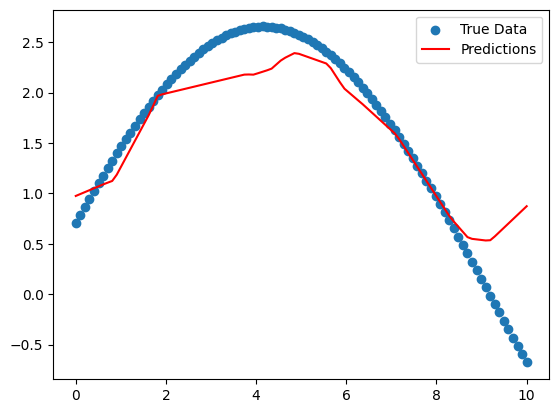

In [31]:
print(T_pred_test.shape)

n = 50
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test["t_tensor"][n], T_pred_test[n], color="red", label="Predictions")
plt.legend()
plt.show()